In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

2025-02-17 01:59:23.658264: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-17 01:59:23.710355: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-17 01:59:23.711044: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-17 01:59:24.518156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Variables de configuración
prediction_col = 'Sales' # Definir el nombre de la columna objetivo que queremos predecir (en este caso, 'Sales')
init_prev_weeks = 2 # Definir el número de semanas desde las que se van a realizar promedios
end_prev_weeks = 8 # Definir el número de semanas hasta las que se van a realizar promedios
augmentation_rounds = 2 # Definir el número de rondas de aumento de datos que se realizarán
look_back = 5  # Número de semanas previas que usamos para predecir la siguiente en los modelos BLSTM

### Functions

In [3]:
def evaluate_regression_model(y_pred, y_true):
    """
    Evalúa un modelo de regresión calculando las métricas RMSE, MSE, MAE, R² y MAPE.

    Parameters:
    - y_pred: Las predicciones del modelo.
    - y_true: Las etiquetas reales.

    Returns:
    - Diccionario con las métricas de evaluación.
    """   
    mse = mean_squared_error(y_true, y_pred) # MSE (Mean Squared Error)
    rmse = np.sqrt(mse) # RMSE (Root Mean Squared Error)
    mae = mean_absolute_error(y_true, y_pred) # MAE (Mean Absolute Error)
    r2 = r2_score(y_true, y_pred) # R² (Coeficiente de determinación)

    # MAPE (Mean Absolute Percentage Error)
    # Evitando división por cero, solo se calcula para valores donde y_true no es cero.
    non_zero_mask = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

    # Diccionario con las métricas
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape
    }

    return metrics

In [4]:
def plot_comparison(y_pred, y_true, X_test, X_train, y_train, y_pred_train, flag_plot_pred_train=True):
    """
    Grafica una comparación entre las ventas reales (y_true) y las predicciones (y_pred) tanto para
    el conjunto de entrenamiento como para el de prueba.

    Parameters:
    - y_pred: Predicciones sobre el conjunto de prueba.
    - y_true: Valores reales del conjunto de prueba.
    - X_test: Conjunto de datos de prueba (usado para los índices).
    - X_train: Conjunto de datos de entrenamiento (usado para los índices).
    - y_train: Valores reales del conjunto de entrenamiento.
    - y_pred_train: Predicciones sobre el conjunto de entrenamiento.
    - flag_plot_pred_train: Bandera que indica si se deben graficar los datos predecidos del entrenamiento
    """
    
    # Crear índices si X_train y X_test son arrays de numpy (sin índice)
    if isinstance(X_train, np.ndarray):
        train_indices = range(len(X_train))  # Crear un rango basado en la longitud
    else:
        train_indices = X_train.index  # Usar el índice si es un DataFrame de pandas

    if isinstance(X_test, np.ndarray):
        test_indices = range(len(X_test))  # Crear un rango basado en la longitud
    else:
        test_indices = X_test.index  # Usar el índice si es un DataFrame de pandas

    # Crear la figura para graficar
    plt.figure(figsize=(12, 6))

    # Graficar los valores reales y las predicciones para el entrenamiento
    plt.plot(train_indices, y_train, label='Ventas reales (Entrenamiento)', color='blue')
    if flag_plot_pred_train:
        plt.plot(train_indices, y_pred_train, label='Predicciones (Entrenamiento)', color='red', linestyle='--')

    # Graficar los valores reales y las predicciones para el test después de los de entrenamiento
    plt.plot(range(len(y_train), len(y_train) + len(y_true)), y_true, label='Ventas reales (Prueba)', color='green')
    plt.plot(range(len(y_pred_train), len(y_pred_train) + len(y_pred)), y_pred, label='Predicciones (Prueba)', color='orange', linestyle='--')

    # Configuración de la gráfica
    plt.legend()
    plt.title('Comparación de Ventas Reales vs Predicciones')
    plt.xlabel('Semana')
    plt.ylabel('Ventas')
    plt.grid(True)
    plt.show()


In [5]:
def augment_data(df, noise_factor_sales=0.01, flip_probability=0.1, random_seed=None):
    """
    Realiza un aumento de datos agregando ruido aleatorio a las columnas de Sales, Promotion y Holiday.
    Para las columnas binarias (Promotion y Holiday), se realiza un cambio aleatorio con una probabilidad dada.

    Parameters:
    - df: DataFrame de entrada con las columnas Sales, Promotion y Holiday.
    - noise_factor_sales: El valor de desviación estándar para agregar ruido a Sales (por defecto 0.01).
    - flip_probability: Probabilidad de flip (0 a 1) para las columnas binarias (por defecto 0.1).
    - random_seed: Semilla para el generador de números aleatorios (opcional para replicabilidad).

    Returns:
    - DataFrame aumentado con ruido añadido a las columnas correspondientes.
    """
    
    # Establecer la semilla si se pasa una
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Copiar el DataFrame original para no modificarlo directamente
    df_augmented = df.copy()

    # Añadir ruido aleatorio a la columna 'Sales'
    df_augmented['Sales'] += np.random.normal(0, noise_factor_sales, size=df['Sales'].shape) * df_augmented['Sales']

    # Para las columnas binarias ('Promotion' y 'Holiday')
    # Realizamos un flip aleatorio con la probabilidad de flip_probability
    for col in ['Promotion', 'Holiday']:
        # Flipear aleatoriamente las etiquetas con la probabilidad flip_probability
        flip_mask = np.random.rand(len(df)) < flip_probability
        df_augmented[col] = df[col].where(~flip_mask, 1 - df[col])

    return df_augmented


In [6]:
def feature_engineering(df_, flag_original):
    """
    Realiza el proceso de ingeniería de características sobre el DataFrame de entrada.
    Se crean nuevas características que incluyen la venta y la promoción de las semanas previas, 
    estadísticas de las últimas semanas y algunas transformaciones adicionales.

    Parameters:
    - df_: DataFrame que contiene las columnas necesarias para el procesamiento (Sales, Promotion, Holiday).
    - flag_original: bandera que se utiliza para agregar la columna 'original' al resultado.

    Returns:
    - df: DataFrame con nuevas características añadidas, como estadísticas de ventas y transformaciones adicionales.
    """
    # Copiar el DataFrame original para evitar modificaciones directas
    df = df_.copy()
    
    # Creación de características que reflejan las ventas, promociones y festividades de la semana anterior
    # La función shift() mueve los valores de una columna para simular la venta o promoción de la semana pasada
    df['Prev_Week_Promotion'] = df['Promotion'].shift(1).fillna(0).astype(int)  # Promoción de la semana anterior
    df['Prev_Week_Holiday'] = df['Holiday'].shift(1).fillna(0).astype(int)  # Festividad de la semana anterior
    df['Prev_Week_Sales'] = df['Sales'].shift(1).fillna(0).astype(int)  # Ventas de la semana anterior
    df['Prev_2_Week_Sales'] = df['Sales'].shift(2).fillna(0).astype(int)  # Ventas de hace dos semanas
    
    # Calcular el promedio y desviación estándar de las ventas, promoción y festividades de las últimas X semanas
    # Esto se realiza mediante una ventana de desplazamiento 'rolling' para promediar las columnas de ventas, promoción y festividades
    for prev_weeks in range(init_prev_weeks, end_prev_weeks+1):
        # Promedios para las 'prev_weeks' semanas anteriores
        df[f'Avg_Promotion_prev_{prev_weeks}_Weeks'] = df['Prev_Week_Promotion'].rolling(window=prev_weeks, min_periods=1).mean()
        df[f'Avg_Holiday_prev_{prev_weeks}_Weeks']  = df['Prev_Week_Holiday'].rolling(window=prev_weeks, min_periods=1).mean()
        df[f'Avg_Sales_prev_{prev_weeks}_Weeks'] = df['Prev_Week_Sales'].rolling(window=prev_weeks, min_periods=1).mean()
        
        # Desviación estándar para las 'prev_weeks' semanas anteriores
        df[f'Std_Sales_prev_{prev_weeks}_Weeks'] = df['Prev_Week_Sales'].rolling(window=prev_weeks, min_periods=1).std()
    
    # Calcular la diferencia y proporción de ventas entre las últimas 2 semanas
    df['Sales_diff_prev_2_weeks'] = df['Prev_Week_Sales'] - df['Prev_2_Week_Sales']  # Diferencia de ventas
    df['Sales_proportion_prev_2_weeks'] = df['Prev_Week_Sales'] / df['Prev_2_Week_Sales']  # Proporción de ventas

    # Crear una característica que combine las promociones y festividades de la semana actual
    df['Promotion_and_Holiday'] = df['Promotion'] * df['Holiday']  # Interacción entre promoción y festividad

    # Logaritmo de las ventas de la semana anterior (se usa para estabilizar la varianza)
    df['Log_Sales_prev_week'] = np.log(df['Prev_Week_Sales'])
    
    # Agregar la columna 'original' del DataFrame original para preservar los datos originales
    df['original'] = flag_original

    # Rellenar los valores nulos con 0
    df = df.fillna(0)
    
    # Reemplazar valores infinitos por 0 para evitar errores durante el entrenamiento de modelos
    df = df.replace([np.inf, -np.inf], 0)
    
    # Devolver el DataFrame con las nuevas características
    return df

### Preprocessing

In [7]:
df_ = pd.read_csv("sales_ml.csv") # Leer el archivo CSV con los datos de ventas
df_ = df_.sort_values(by='Week') # Ordenar el DataFrame por la columna 'Week' (Semana) para tener los datos en orden cronológico
df_eval = df_[df_['Sales'].isna()].copy() # Crear un DataFrame con las filas donde la columna 'Sales' es NaN (es decir, donde faltan las ventas)
df = df_[df_['Sales'].notna()].copy() # Crear un DataFrame con las filas donde la columna 'Sales' no es NaN (es decir, donde las ventas están presentes)
df.head(2) # Mostrar las primeras dos filas del DataFrame 'df' para verificar los datos

,Week,Product,Sales,Promotion,Holiday
0,1,Product_1,152.0,1,0
1,2,Product_1,485.0,0,0


In [8]:
# Generar las características para el DataFrame 'df' usando la función 'feature_engineering'
df_features = feature_engineering(df, 'True')
df_concat = df_features.copy() # Hacer una copia del DataFrame de características para luego concatenar los datos aumentados

# Realizar las rondas de aumento de datos
for round in range(augmentation_rounds):
    # Aumentar los datos en cada ronda y generar nuevas características con 'feature_engineering'
    df_aux = feature_engineering(augment_data(df, random_seed=round), 'False')
    
    # Concatenar los nuevos datos aumentados al DataFrame original
    # Se realiza un 'concat' y luego se ordenan por la columna 'Week' para mantener el orden cronológico
    df_concat = pd.concat([df_concat, df_aux], ignore_index=True).sort_values(by=['Week', 'Sales'], ascending=[True, False])

# Resetear los índices del DataFrame concatenado para asegurarse de que sean continuos
df_concat.reset_index(drop=True, inplace=True)

# Obtener los índices originales (donde la columna 'original' es True) para identificarlos más tarde
df_index_original = df_concat[df_concat['original'] == True].index

# Crear el DataFrame final, eliminando las columnas no necesarias ('Product', 'Week', 'original')
df_final = df_concat.drop(columns=['Product', 'Week', 'original'])

/home/thinkpad/anaconda3/envs/python_3_8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thinkpad/anaconda3/envs/python_3_8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thinkpad/anaconda3/envs/python_3_8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# Mostrar las primeras 2 filas del DataFrame
df_final.head(2)

,Sales,Promotion,Holiday,Prev_Week_Promotion,Prev_Week_Holiday,Prev_Week_Sales,Prev_2_Week_Sales,Avg_Promotion_prev_2_Weeks,Avg_Holiday_prev_2_Weeks,Avg_Sales_prev_2_Weeks,...,Avg_Sales_prev_7_Weeks,Std_Sales_prev_7_Weeks,Avg_Promotion_prev_8_Weeks,Avg_Holiday_prev_8_Weeks,Avg_Sales_prev_8_Weeks,Std_Sales_prev_8_Weeks,Sales_diff_prev_2_weeks,Sales_proportion_prev_2_weeks,Promotion_and_Holiday,Log_Sales_prev_week
0,154.681360,1,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0
1,154.469005,1,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0


In [10]:
# Separar las características (X) de la columna objetivo (y)
X = df_final.drop(columns=prediction_col)
y = df_final[prediction_col]

In [11]:
# Definir el índice de división (80% entrenamiento, 20% prueba)
train_size = int(len(df_final) * 0.8)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Lightgbm model

In [12]:
# Crear el dataset de LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Parámetros del modelo LightGBM
params = {
    'objective': 'regression',  # Tipo de tarea (regresión para predecir un número continuo)
    'metric': 'rmse',           # Medida para evaluar el rendimiento (root mean squared error)
    'boosting_type': 'gbdt',    # Tipo de boosting (Gradient Boosting Decision Tree)
    'num_leaves': 31,           # Número de hojas en los árboles
    'learning_rate': 0.1,      # Tasa de aprendizaje
    'feature_fraction': 0.9,    # Fracción de características que se utilizan en cada iteración
    'bagging_fraction': 0.8,    # Fracción de datos utilizados en cada iteración
    'bagging_freq': 5,          # Frecuencia de bagging (1 cada 5 iteraciones)
    'verbose': -1,               # Para evitar mensajes detallados
    'max_depth': 6              # Limita la profundidad máxima de los árboles
}

# Entrenar el modelo LightGBM con early stopping
num_round = 1000  # Número de iteraciones
model_lgbm = lgb.train(params, train_data, num_round, valid_sets=[test_data],
                  callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)])

# Hacer predicciones con el modelo entrenado
y_pred = model_lgbm.predict(X_test, num_iteration=model_lgbm.best_iteration)
y_pred_train = model_lgbm.predict(X_train, num_iteration=model_lgbm.best_iteration)

# Evaluación del modelo: Calcular el RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 147.834
Early stopping, best iteration is:
[30]	valid_0's rmse: 137.142
Root Mean Squared Error (RMSE): 137.14234294416818


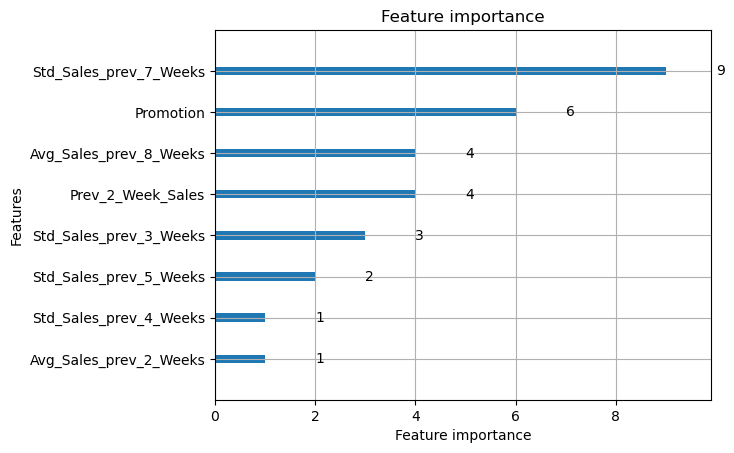

In [13]:
lgb.plot_importance(model_lgbm, max_num_features=10, importance_type='split')
plt.show()

In [14]:
metrics_lgbm = evaluate_regression_model(y_pred, y_test)
metrics_lgbm

{'MSE': 18808.022228215832,
 'RMSE': 137.14234294416818,
 'MAE': 110.86247336946747,
 'R²': -1.3489838470268114,
 'MAPE': 27.14149808679509}

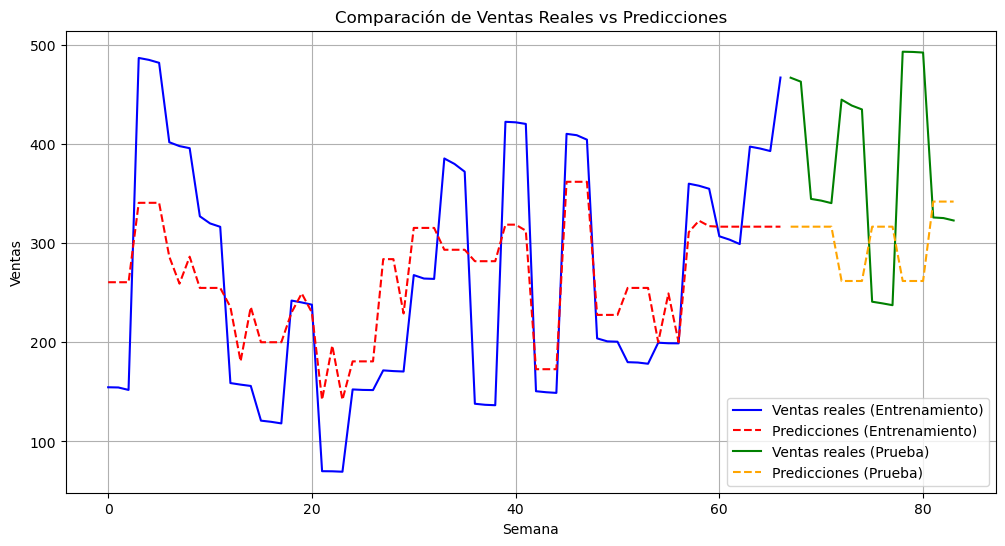

In [15]:
plot_comparison(y_pred, y_test, X_test, X_train, y_train, y_pred_train)

# Linear regression

In [16]:
# Escalar las características (opcional, para regresión lineal y otros modelos)
scaler_lr = StandardScaler()
X_train_scaled = scaler_lr.fit_transform(X_train)
X_test_scaled = scaler_lr.transform(X_test)

# Regresión lineal
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred_lr = linear_regressor.predict(X_test_scaled)
y_train_pred_lr = linear_regressor.predict(X_train_scaled)

# Calcular el RMSE para la regresión lineal
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"RMSE de Regresión Lineal: {rmse_lr}")

RMSE de Regresión Lineal: 127.70914493149377


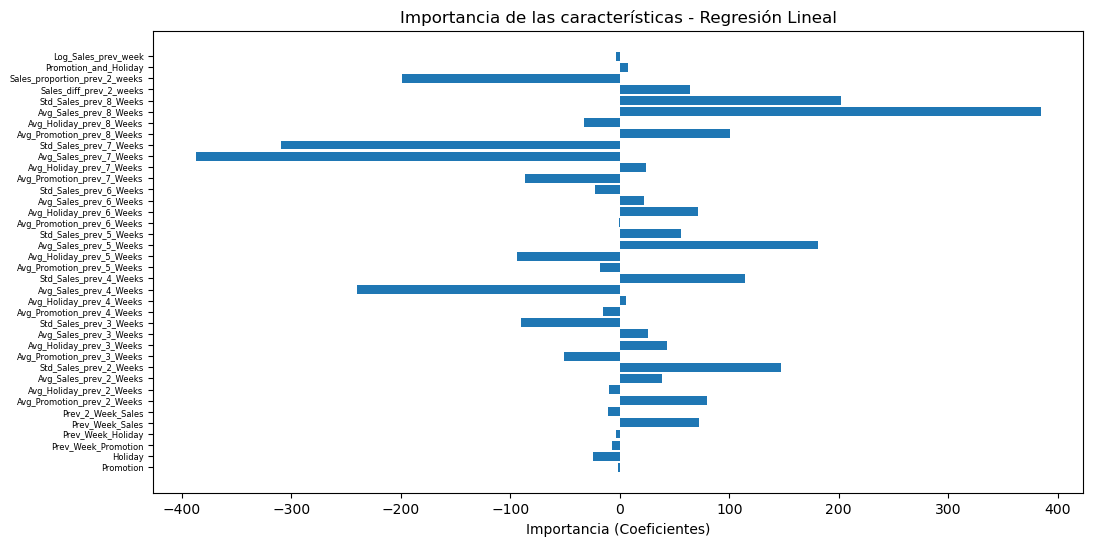

In [17]:
# Obtener los coeficientes de la regresión lineal (importancia de características)
coef = linear_regressor.coef_

# Crear un gráfico de barras para mostrar la importancia de las características
plt.figure(figsize=(12, 6))
plt.barh(np.arange(len(coef)), coef, align='center')
plt.yticks(np.arange(len(coef)), X_train.columns, fontsize=6)  # Cambiar el tamaño de la fuente aquí
plt.xlabel('Importancia (Coeficientes)')
plt.title('Importancia de las características - Regresión Lineal')
plt.show()

In [18]:
metrics_lr = evaluate_regression_model(y_pred_lr, y_test)
metrics_lr

{'MSE': 16309.62569913328,
 'RMSE': 127.70914493149377,
 'MAE': 101.99622816240773,
 'R²': -1.0369524691885537,
 'MAPE': 28.334989987755915}

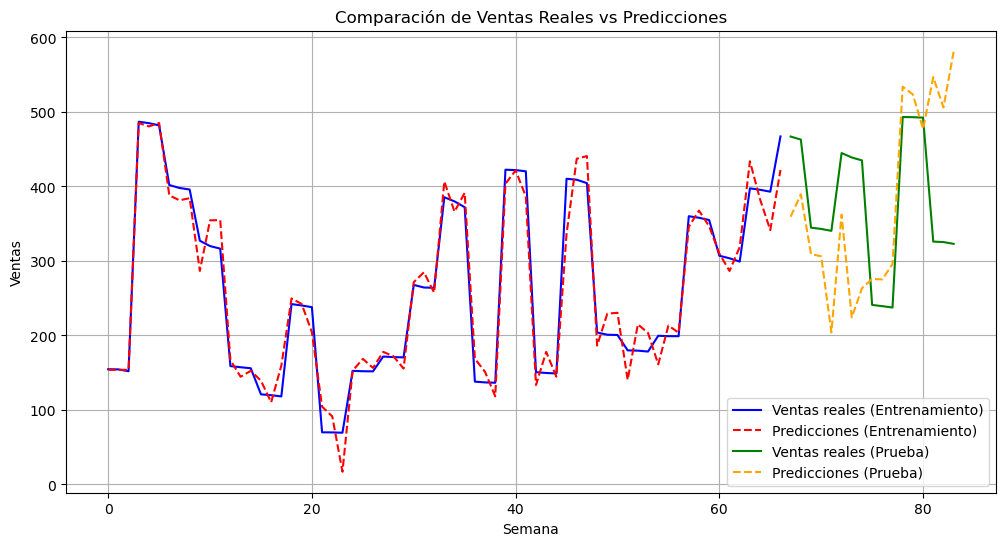

In [19]:
plot_comparison(y_pred_lr, y_test, X_test, X_train, y_train, y_train_pred_lr )

# XGBoost

In [20]:
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=200,              # Ajusta a un valor más bajo para evitar sobreajuste
    learning_rate=0.01,            # Utiliza un learning rate bajo
    max_depth=5,                   # Árboles más pequeños
    min_child_weight=1,            # Ajusta a 1 para evitar divisiones demasiado específicas
    subsample=0.8,                 # Submuestra más pequeña para evitar sobreajuste
    colsample_bytree=0.7,          # Menos características por árbol para generalizar mejor
    gamma=0.1,                     # Un poco de regularización para evitar sobreajuste
    reg_alpha=0.2,                 # Regularización L1 ligera
    reg_lambda=0.5                 # Regularización L2 ligera
)

# Entrenar el modelo
model_xgb.fit(X_train, y_train)

# Hacer predicciones sobre los datos de prueba
y_pred_xgb= model_xgb.predict(X_test)
y_train_pred_xgb= model_xgb.predict(X_train)

# Evaluación del modelo: Calcular el RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 115.51116587698057


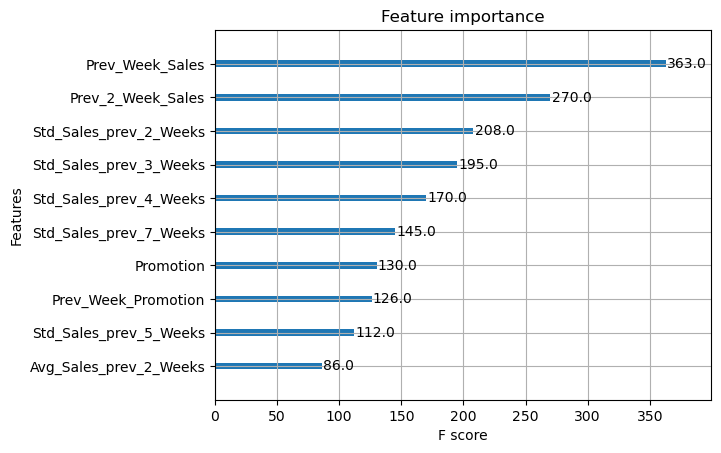

In [21]:
# Importancia de las características
xgb.plot_importance(model_xgb, max_num_features=10, importance_type='weight')
plt.show()

In [22]:
metrics_xgb = evaluate_regression_model(y_pred_xgb, y_test)
metrics_xgb

{'MSE': 13342.829442259319,
 'RMSE': 115.51116587698057,
 'MAE': 94.66840894933345,
 'R²': -0.6664214053554998,
 'MAPE': 22.934674493886337}

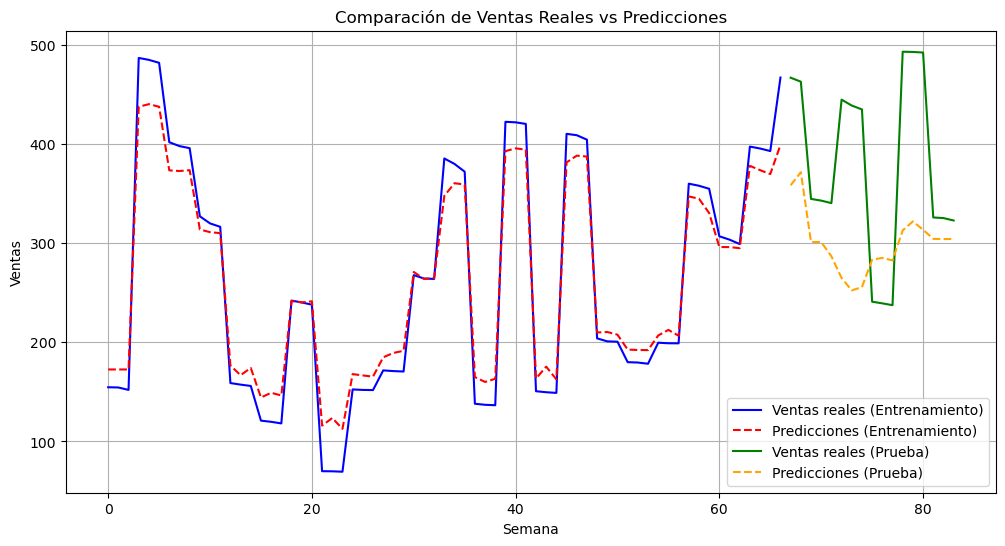

In [23]:
plot_comparison(y_pred_xgb, y_test,  X_test, X_train, y_train, y_train_pred_xgb)

# Arima

In [24]:
train_size_arima = int(len(df) * 0.8)
train, test = df[:train_size_arima], df[train_size_arima:]

model_arima = ARIMA(train['Sales'], order=(5, 1, 0))  # (p, d, q)
model_fit = model_arima.fit()
print(model_fit.summary())
forecast = model_fit.forecast(steps=len(test))

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   22
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -130.736
Date:                Mon, 17 Feb 2025   AIC                            273.471
Time:                        01:59:27   BIC                            279.738
Sample:                             0   HQIC                           274.831
                                 - 22                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6616      0.288     -2.295      0.022      -1.227      -0.097
ar.L2         -0.1387      0.356     -0.390      0.697      -0.836       0.558
ar.L3         -0.4162      0.279     -1.493      0.1

In [25]:
metrics_arima = evaluate_regression_model(forecast, test['Sales'])
metrics_arima

{'MSE': 14739.764499964886,
 'RMSE': 121.40743181521009,
 'MAE': 100.88848953779382,
 'R²': -0.9136131168069006,
 'MAPE': 25.37950534368603}

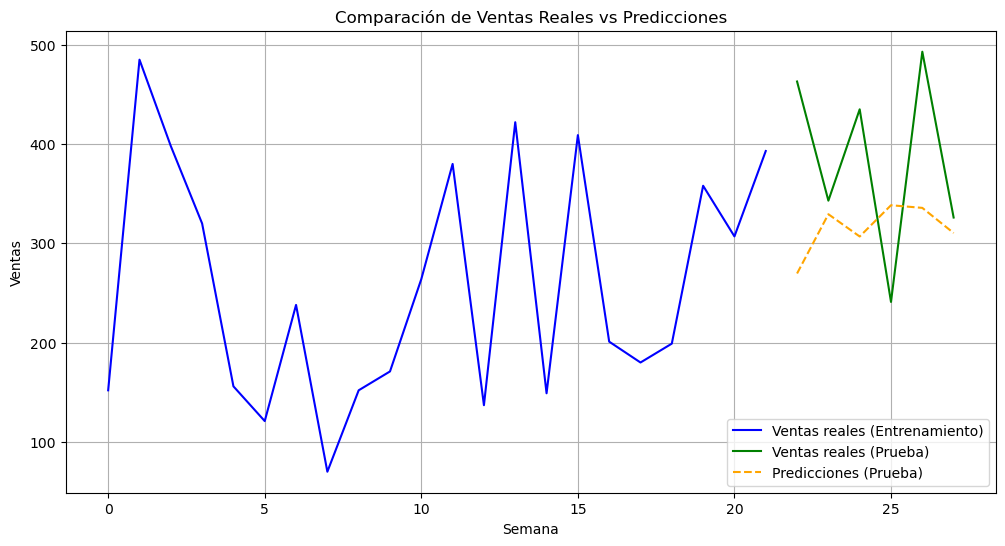

In [26]:
plot_comparison(forecast, test['Sales'], test, train, train['Sales'], train['Sales'], False)

# Arimax

In [27]:
model_arimax = ARIMA(y_train, exog=X_train, order=(1, 1, 1))
model_fit_arimax = model_arimax.fit()
y_pred_arimax = model_fit_arimax.forecast(steps=len(X_test), exog=X_test)
y_train_pred_arimax = model_fit_arimax.forecast(steps=len(X_train), exog=X_train)

/home/thinkpad/anaconda3/envs/python_3_8/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
metrics_arimax = evaluate_regression_model(y_pred_arimax, y_test)
metrics_arimax

{'MSE': 1871.0691554906264,
 'RMSE': 43.25585689234033,
 'MAE': 36.58421808876441,
 'R²': 0.7663172039256725,
 'MAPE': 10.151389467321046}

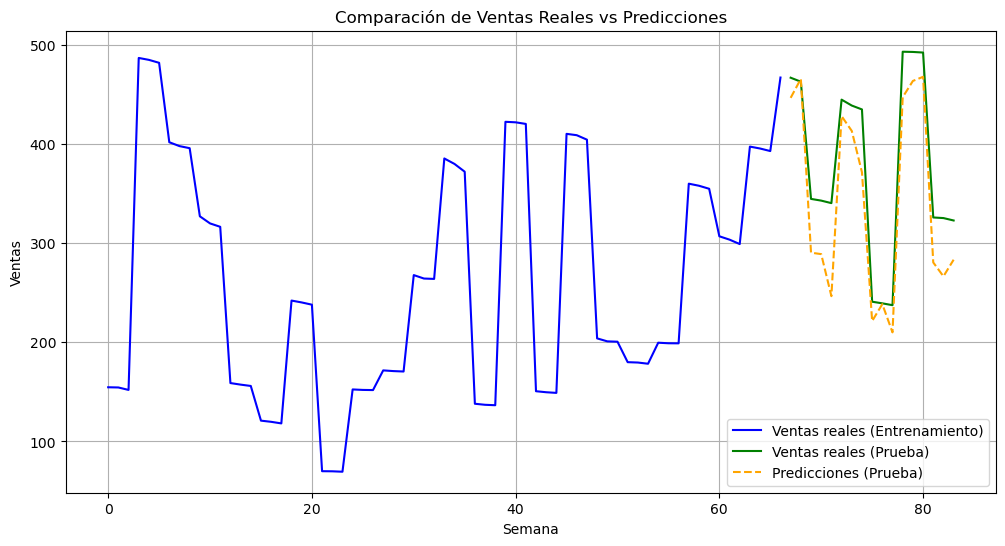

In [29]:
plot_comparison(y_pred_arimax, y_test,  X_test, X_train, y_train, y_train_pred_arimax, False)

# BLSTM

In [30]:
# Configurar para usar la CPU
tf.config.set_visible_devices([], 'GPU')  # Desactiva todas las GPUs

# Normalizar las variables para que estén en el rango [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_final)

# Crear las secuencias de datos para entrenar el modelo (X, y)
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back, 0])  # 0 corresponde a 'Sales' que es la variable objetivo
    return np.array(X), np.array(y)


X_blstm, y_blstm = create_dataset(scaled_data, look_back)

# Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size_blstm = int(len(X_blstm) * 0.8)
X_train_blstm, X_test_blstm = X_blstm[:train_size_blstm], X_blstm[train_size_blstm:]
y_train_blstm, y_test_blstm = y_blstm[:train_size_blstm], y_blstm[train_size_blstm:]

# Definir el modelo BLSTM (Bidirectional LSTM)
model = Sequential()
# Añadir capa LSTM bidireccional con Dropout
model.add(Bidirectional(LSTM(units=64, activation='relu', return_sequences=False), input_shape=(look_back, X_train_blstm.shape[2])))
model.add(Dropout(0.2))  # Dropout para evitar overfitting
model.add(Dense(units=1)) # Capa densa para la predicción
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error') # Reducir la tasa de aprendizaje

# Entrenar el modelo
history = model.fit(X_train_blstm, y_train_blstm, epochs=500, batch_size=16, validation_data=(X_test_blstm, y_test_blstm), verbose=1)

# Hacer predicciones sobre el conjunto de prueba
y_pred_blstm = model.predict(X_test_blstm)

# Hacer predicciones sobre el conjunto de entrenamiento
y_train_pred = model.predict(X_train_blstm)
y_test_blstm.shape, y_pred_blstm.shape, X_train_blstm.shape[2]

# Asegúrandonos de que todas las variables son numpy arrays
y_test_blstm = np.array(y_test_blstm)
y_pred_blstm = np.array(y_pred_blstm)
y_train = np.array(y_train)
y_train_pred = np.array(y_train_pred)

# Revertir la normalización de las predicciones y los valores reales para el conjunto de prueba
y_test_blstm_rescaled = scaler.inverse_transform(np.hstack((y_test_blstm.reshape(-1, 1), np.zeros((len(y_test_blstm), df_final.shape[1]-1)))))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred_blstm.reshape(-1, 1), np.zeros((len(y_pred_blstm), df_final.shape[1]-1)))))[:, 0]

# Revertir la normalización de las predicciones y los valores reales para el conjunto de entrenamiento
y_train_rescaled = scaler.inverse_transform(np.hstack((y_train_blstm.reshape(-1, 1), np.zeros((len(y_train_blstm), df_final.shape[1]-1)))))[:, 0]
y_train_pred_rescaled = scaler.inverse_transform(np.hstack((y_train_pred.reshape(-1, 1), np.zeros((len(y_train_pred), df_final.shape[1]-1)))))[:, 0]


Epoch 1/500
4/4 [==============================] - 2s 91ms/step - loss: 0.2254 - val_loss: 0.1832
Epoch 2/500
4/4 [==============================] - 0s 10ms/step - loss: 0.1872 - val_loss: 0.1420
Epoch 3/500
4/4 [==============================] - 0s 10ms/step - loss: 0.1462 - val_loss: 0.1096
Epoch 4/500
4/4 [==============================] - 0s 11ms/step - loss: 0.1349 - val_loss: 0.0865
Epoch 5/500
4/4 [==============================] - 0s 11ms/step - loss: 0.1351 - val_loss: 0.0712
Epoch 6/500
4/4 [==============================] - 0s 9ms/step - loss: 0.1120 - val_loss: 0.0615
Epoch 7/500
4/4 [==============================] - 0s 10ms/step - loss: 0.1078 - val_loss: 0.0559
Epoch 8/500
4/4 [==============================] - 0s 10ms/step - loss: 0.0866 - val_loss: 0.0535
Epoch 9/500
4/4 [==============================] - 0s 11ms/step - loss: 0.1032 - val_loss: 0.0531
Epoch 10/500
4/4 [==============================] - 0s 11ms/step - loss: 0.1022 - val_loss: 0.0537
Epoch 11/500
4/4 [==

In [31]:
metrics_blstm = evaluate_regression_model(y_pred_rescaled, y_test_blstm_rescaled)
metrics_blstm

{'MSE': 12951.092178031127,
 'RMSE': 113.80286542100392,
 'MAE': 98.33197927111392,
 'R²': -0.6196338993865704,
 'MAPE': 29.391000510779016}

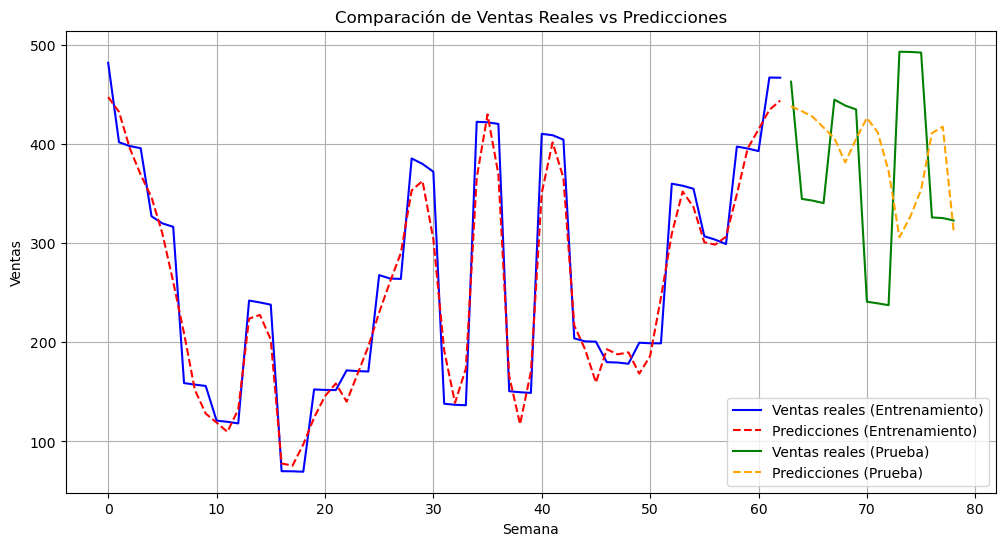

In [32]:
plot_comparison(y_pred_rescaled, y_test_blstm_rescaled, X_test_blstm, X_train_blstm, y_train_rescaled, y_train_pred_rescaled)

# Hyperparmeter tuning with Optuna

In [33]:
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd


# Definir la función de optimización
def objective(trial):
    # Probar diferentes valores para los parámetros del modelo
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),           # Número de hojas
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),  # Tasa de aprendizaje
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),  # Fracción de características
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),  # Fracción de datos
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),            # Frecuencia de bagging
        'max_depth': trial.suggest_int('max_depth', 3, 12),                   # Profundidad máxima del árbol
        'verbose': -1
    }

    # Crear el dataset de LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Entrenar el modelo con los parámetros sugeridos por Optuna
    num_round = 1000
    model = lgb.train(params, train_data, num_round, valid_sets=[test_data],
                      callbacks=[lgb.early_stopping(stopping_rounds=50)])
    
    # Realizar predicciones y calcular el RMSE
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calcular RMSE

    return rmse

# Crear el estudio de Optuna y realizar la optimización
study = optuna.create_study(direction='minimize')  # Minimizar el RMSE
study.optimize(objective, n_trials=50)  # Realizar 50 intentos

# Imprimir los mejores parámetros y el mejor RMSE
print('Best RMSE: ', study.best_value)
print('Best parameters: ', study.best_params)

# Puedes usar los mejores parámetros para entrenar un modelo final si lo deseas
best_params = study.best_params
final_model = lgb.train(best_params, train_data, num_round, valid_sets=[test_data])

# Realizar las predicciones con el mejor modelo
final_predictions = final_model.predict(X_test, num_iteration=final_model.best_iteration)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print(f"Final RMSE with optimized parameters: {final_rmse}")


[I 2025-02-17 01:59:49,107] A new study created in memory with name: no-name-f7cfa892-4e17-47b8-9436-fe667bab8051
[I 2025-02-17 01:59:49,157] Trial 0 finished with value: 133.74571564521003 and parameters: {'num_leaves': 69, 'learning_rate': 0.03507078471774881, 'feature_fraction': 0.9685637720710647, 'bagging_fraction': 0.7942495589625101, 'bagging_freq': 6, 'max_depth': 4}. Best is trial 0 with value: 133.74571564521003.
[I 2025-02-17 01:59:49,170] Trial 1 finished with value: 132.5386375495472 and parameters: {'num_leaves': 96, 'learning_rate': 0.08144807642653869, 'feature_fraction': 0.7078603001051776, 'bagging_fraction': 0.8299329029472989, 'bagging_freq': 8, 'max_depth': 7}. Best is trial 1 with value: 132.5386375495472.
[I 2025-02-17 01:59:49,186] Trial 2 finished with value: 139.83522157468065 and parameters: {'num_leaves': 23, 'learning_rate': 0.0192836304308951, 'feature_fraction': 0.863386749504948, 'bagging_fraction': 0.8251657417447982, 'bagging_freq': 3, 'max_depth': 7}.

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 133.746
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 132.539
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 139.835
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 140.882
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 141.259
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 137.001
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's rmse: 135.33
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 121.093
Tra

[I 2025-02-17 01:59:49,330] Trial 9 finished with value: 124.90761922726526 and parameters: {'num_leaves': 68, 'learning_rate': 0.061250516250989755, 'feature_fraction': 0.9846634537845159, 'bagging_fraction': 0.7086944035767425, 'bagging_freq': 4, 'max_depth': 3}. Best is trial 7 with value: 121.09330897811367.
[I 2025-02-17 01:59:49,374] Trial 10 finished with value: 123.03823746724117 and parameters: {'num_leaves': 100, 'learning_rate': 0.09321904567017755, 'feature_fraction': 0.8126794486060726, 'bagging_fraction': 0.7232670714423651, 'bagging_freq': 6, 'max_depth': 5}. Best is trial 7 with value: 121.09330897811367.
[I 2025-02-17 01:59:49,418] Trial 11 finished with value: 123.79988384477298 and parameters: {'num_leaves': 100, 'learning_rate': 0.08601999048383759, 'feature_fraction': 0.8155869040469019, 'bagging_fraction': 0.7032449466041008, 'bagging_freq': 6, 'max_depth': 5}. Best is trial 7 with value: 121.09330897811367.
[I 2025-02-17 01:59:49,496] Trial 12 finished with value

Early stopping, best iteration is:
[25]	valid_0's rmse: 124.908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 123.038
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's rmse: 123.8
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 128.863


[I 2025-02-17 01:59:49,551] Trial 13 finished with value: 129.09880131257347 and parameters: {'num_leaves': 52, 'learning_rate': 0.048096097041000055, 'feature_fraction': 0.7692376047471738, 'bagging_fraction': 0.7540100330867294, 'bagging_freq': 7, 'max_depth': 3}. Best is trial 7 with value: 121.09330897811367.
[I 2025-02-17 01:59:49,603] Trial 14 finished with value: 130.48761580872872 and parameters: {'num_leaves': 50, 'learning_rate': 0.038930995386113484, 'feature_fraction': 0.8958656151830587, 'bagging_fraction': 0.750946840629558, 'bagging_freq': 1, 'max_depth': 6}. Best is trial 7 with value: 121.09330897811367.
[I 2025-02-17 01:59:49,653] Trial 15 finished with value: 128.98369157266225 and parameters: {'num_leaves': 86, 'learning_rate': 0.09312723776547548, 'feature_fraction': 0.820194302457848, 'bagging_fraction': 0.7872507937524209, 'bagging_freq': 5, 'max_depth': 5}. Best is trial 7 with value: 121.09330897811367.
[I 2025-02-17 01:59:49,709] Trial 16 finished with value: 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 129.099
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's rmse: 130.488
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 128.984
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's rmse: 122.498


[I 2025-02-17 01:59:49,755] Trial 17 finished with value: 133.4289558755147 and parameters: {'num_leaves': 84, 'learning_rate': 0.027388689991875957, 'feature_fraction': 0.7386325450190965, 'bagging_fraction': 0.7906420328308686, 'bagging_freq': 8, 'max_depth': 9}. Best is trial 7 with value: 121.09330897811367.
[I 2025-02-17 01:59:49,807] Trial 18 finished with value: 122.99165132791221 and parameters: {'num_leaves': 56, 'learning_rate': 0.05192763929384655, 'feature_fraction': 0.7761686935858222, 'bagging_fraction': 0.7269639429582784, 'bagging_freq': 9, 'max_depth': 3}. Best is trial 7 with value: 121.09330897811367.
[I 2025-02-17 01:59:49,853] Trial 19 finished with value: 142.4939491520247 and parameters: {'num_leaves': 35, 'learning_rate': 0.010349192676421298, 'feature_fraction': 0.8445644850231334, 'bagging_fraction': 0.9317020942280686, 'bagging_freq': 7, 'max_depth': 10}. Best is trial 7 with value: 121.09330897811367.
[I 2025-02-17 01:59:49,902] Trial 20 finished with value:

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 133.429
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's rmse: 122.992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 142.494
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 121.189
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's rmse: 120.2


[I 2025-02-17 01:59:49,992] Trial 22 finished with value: 129.55979337030365 and parameters: {'num_leaves': 79, 'learning_rate': 0.039350443034476684, 'feature_fraction': 0.9038668795231969, 'bagging_fraction': 0.7590159466618212, 'bagging_freq': 7, 'max_depth': 4}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:50,044] Trial 23 finished with value: 139.01759326759216 and parameters: {'num_leaves': 91, 'learning_rate': 0.057671966866866126, 'feature_fraction': 0.9295565342719377, 'bagging_fraction': 0.8070744970760233, 'bagging_freq': 4, 'max_depth': 6}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:50,089] Trial 24 finished with value: 134.5447198792573 and parameters: {'num_leaves': 94, 'learning_rate': 0.04430925980127329, 'feature_fraction': 0.880370903215304, 'bagging_fraction': 0.772906661323782, 'bagging_freq': 7, 'max_depth': 4}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:50,133] Trial 25 finished with value

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 129.56
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 139.018
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 134.545
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's rmse: 122.118
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's rmse: 127.617


[I 2025-02-17 01:59:50,222] Trial 27 finished with value: 137.64280932706177 and parameters: {'num_leaves': 43, 'learning_rate': 0.039768543783845006, 'feature_fraction': 0.8823773983389962, 'bagging_fraction': 0.8124729402779618, 'bagging_freq': 6, 'max_depth': 3}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:50,265] Trial 28 finished with value: 133.55655319232648 and parameters: {'num_leaves': 83, 'learning_rate': 0.05275384113784569, 'feature_fraction': 0.9113557329701659, 'bagging_fraction': 0.7752438469236556, 'bagging_freq': 4, 'max_depth': 5}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:50,307] Trial 29 finished with value: 139.02999283854265 and parameters: {'num_leaves': 73, 'learning_rate': 0.03428098277020561, 'feature_fraction': 0.9598277277723944, 'bagging_fraction': 0.8721758710590043, 'bagging_freq': 9, 'max_depth': 4}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:50,353] Trial 30 finished with val

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's rmse: 137.643
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 133.557
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 139.03
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 121.025
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 124.614


[I 2025-02-17 01:59:50,445] Trial 32 finished with value: 127.55271435290358 and parameters: {'num_leaves': 94, 'learning_rate': 0.02391137692727068, 'feature_fraction': 0.8858190257738355, 'bagging_fraction': 0.7423876043645774, 'bagging_freq': 6, 'max_depth': 7}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:50,492] Trial 33 finished with value: 124.18640409509908 and parameters: {'num_leaves': 100, 'learning_rate': 0.03479988084807101, 'feature_fraction': 0.8661245138697424, 'bagging_fraction': 0.7184988574391953, 'bagging_freq': 8, 'max_depth': 3}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:50,537] Trial 34 finished with value: 132.8433278866547 and parameters: {'num_leaves': 91, 'learning_rate': 0.04309828873697, 'feature_fraction': 0.9338767674062132, 'bagging_fraction': 0.7770409732607232, 'bagging_freq': 6, 'max_depth': 4}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:50,584] Trial 35 finished with value: 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 127.553
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's rmse: 124.186
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 132.843
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's rmse: 125.491
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 124.986


[I 2025-02-17 01:59:50,675] Trial 37 finished with value: 139.50976263676614 and parameters: {'num_leaves': 96, 'learning_rate': 0.014066500622303097, 'feature_fraction': 0.9117512949675, 'bagging_fraction': 0.9954246657466447, 'bagging_freq': 9, 'max_depth': 5}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:50,720] Trial 38 finished with value: 138.97341346757574 and parameters: {'num_leaves': 91, 'learning_rate': 0.04766730571107887, 'feature_fraction': 0.8938511132426679, 'bagging_fraction': 0.8074806753118158, 'bagging_freq': 8, 'max_depth': 4}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:50,763] Trial 39 finished with value: 138.17856183870012 and parameters: {'num_leaves': 65, 'learning_rate': 0.06342084407780575, 'feature_fraction': 0.838666003777273, 'bagging_fraction': 0.832302907380178, 'bagging_freq': 6, 'max_depth': 6}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:50,837] Trial 40 finished with value: 1

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 139.51
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	valid_0's rmse: 138.973
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 138.179
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's rmse: 127.905


[I 2025-02-17 01:59:50,888] Trial 41 finished with value: 125.80260578981853 and parameters: {'num_leaves': 79, 'learning_rate': 0.030627546123394415, 'feature_fraction': 0.9416927879518111, 'bagging_fraction': 0.7331183938456477, 'bagging_freq': 10, 'max_depth': 6}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:50,936] Trial 42 finished with value: 126.31027972142746 and parameters: {'num_leaves': 87, 'learning_rate': 0.030827231617885278, 'feature_fraction': 0.997845331109113, 'bagging_fraction': 0.7192533125292713, 'bagging_freq': 9, 'max_depth': 7}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:50,985] Trial 43 finished with value: 123.56153061590925 and parameters: {'num_leaves': 82, 'learning_rate': 0.03339315433216558, 'feature_fraction': 0.9691065732953382, 'bagging_fraction': 0.7138520072913065, 'bagging_freq': 8, 'max_depth': 8}. Best is trial 21 with value: 120.20032143818291.
[I 2025-02-17 01:59:51,032] Trial 44 finished with va

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 125.803
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's rmse: 126.31
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	valid_0's rmse: 123.562
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's rmse: 123.408
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's rmse: 119.552


[I 2025-02-17 01:59:51,082] Trial 45 finished with value: 119.5520232008881 and parameters: {'num_leaves': 76, 'learning_rate': 0.04320281130936895, 'feature_fraction': 0.9190328764889474, 'bagging_fraction': 0.7333558743795303, 'bagging_freq': 7, 'max_depth': 11}. Best is trial 45 with value: 119.5520232008881.
[I 2025-02-17 01:59:51,126] Trial 46 finished with value: 137.58076322218415 and parameters: {'num_leaves': 74, 'learning_rate': 0.055377505282994316, 'feature_fraction': 0.9175419290607053, 'bagging_fraction': 0.9754852612744118, 'bagging_freq': 7, 'max_depth': 11}. Best is trial 45 with value: 119.5520232008881.
[I 2025-02-17 01:59:51,173] Trial 47 finished with value: 118.84539019076598 and parameters: {'num_leaves': 87, 'learning_rate': 0.044998331809039754, 'feature_fraction': 0.8705860540008975, 'bagging_fraction': 0.7150521179036821, 'bagging_freq': 6, 'max_depth': 11}. Best is trial 47 with value: 118.84539019076598.
[I 2025-02-17 01:59:51,219] Trial 48 finished with va

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 137.581
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's rmse: 118.845
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 122.33
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 127.024
Best RMSE:  118.84539019076598
Best parameters:  {'num_leaves': 87, 'learning_rate': 0.044998331809039754, 'feature_fraction': 0.8705860540008975, 'bagging_fraction': 0.7150521179036821, 'bagging_freq': 6, 'max_depth': 11}
Final RMSE with optimized parameters: 159.7179949680712


In [34]:
# Realizar las predicciones con el mejor modelo
final_predictions = final_model.predict(X_test, num_iteration=final_model.best_iteration)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print(f"Final RMSE with optimized parameters: {final_rmse}")

Final RMSE with optimized parameters: 159.7179949680712


In [35]:
# Aunque se realizó la búsqueda de hiperparámetros, estos no fueron mejores que aquellos seleccionados de forma empírica

# Metrics

In [36]:
metrics_df = pd.DataFrame({
    'LGBM': metrics_lgbm.values(),
    'LR': metrics_lr.values(),
    'XGB': metrics_xgb.values(),
    'ARIMA': metrics_arima.values(),
    'ARIMAX': metrics_arimax.values(),
    'BLSTM': metrics_blstm.values()
}, index=metrics_lgbm.keys())

# Mostrar la tabla con las métricas
metrics_df = metrics_df.transpose()

In [37]:
metrics_df

,MSE,RMSE,MAE,R²,MAPE
LGBM,18808.022228,137.142343,110.862473,-1.348984,27.141498
LR,16309.625699,127.709145,101.996228,-1.036952,28.334990
XGB,13342.829442,115.511166,94.668409,-0.666421,22.934674
ARIMA,14739.764500,121.407432,100.888490,-0.913613,25.379505
ARIMAX,1871.069155,43.255857,36.584218,0.766317,10.151389
BLSTM,12951.092178,113.802865,98.331979,-0.619634,29.391001


# Evaluation

In [38]:
def evaluate_model(df_aux, model, feature_engineering, model_type, scaler=None, end_prev_weeks=8):
    """
    Función genérica para la evaluación de modelos.
    
    df_aux: DataFrame
        DataFrame que contiene los datos de ventas y otras características.
    model: modelo entrenado
        El modelo previamente entrenado que se va a utilizar para la predicción.
    feature_engineering: función
        La función que realiza el procesamiento de características para la evaluación.
    model_type: str
        Tipo de modelo ('LGBM', 'LinearRegression', 'XGB', 'ARIMAX')
    scaler: (opcional) 
        Si el modelo requiere un escalado, se debe proporcionar el scaler correspondiente.
    end_prev_weeks: int
        Número de semanas previas a usar para las predicciones.
        
    Retorna el DataFrame actualizado con las predicciones de ventas.
    """
    for i, row in df_eval.iterrows():
        # Filtrar las semanas anteriores
        df_weeks_previous = df_aux[df_aux['Week'] <= row['Week']].tail(end_prev_weeks + 1)
        
        # Generar las características para la evaluación
        df_eval_features = feature_engineering(df_weeks_previous, 'True')
        X_eval = df_eval_features.iloc[[-1]].drop(columns=['Product', 'Week', 'original', 'Sales'])

        # Predicción según el tipo de modelo
        if model_type == 'LGBM':
            y_eval_pred = model.predict(X_eval)
        elif model_type == 'LinearRegression':
            y_eval_pred = model.predict(scaler.transform(X_eval))  # Escalado para regresión lineal
        elif model_type == 'XGB':
            y_eval_pred = model.predict(X_eval)
        elif model_type == 'ARIMAX':
            y_eval_pred = model.forecast(steps=1, exog=X_eval).values[0]
        else:
            raise ValueError(f"Modelo {model_type} no reconocido")

        # Asignar la predicción a la columna 'Sales' en el DataFrame
        df_aux.loc[df_aux['Week'] == row['Week'], 'Sales'] = y_eval_pred
    
    return df_aux

In [39]:
# Evaluación con LGBM
df_aux_lgbm = df_.copy()
df_aux_lgbm = evaluate_model(df_aux_lgbm, model_lgbm, feature_engineering, 'LGBM', end_prev_weeks=end_prev_weeks)

# Evaluación con Linear Regression
df_aux_lr = df_.copy()
df_aux_lr = evaluate_model(df_aux_lr, linear_regressor, feature_engineering, 'LinearRegression', scaler_lr, end_prev_weeks=end_prev_weeks)

# Evaluación con XGBoost
df_aux_xgb = df_.copy()
df_aux_xgb = evaluate_model(df_aux_xgb, model_xgb, feature_engineering, 'XGB', end_prev_weeks=end_prev_weeks)

# Evaluación con ARIMAX
df_aux_arimax = df_.copy()
df_aux_arimax = evaluate_model(df_aux_arimax, model_fit_arimax, feature_engineering, 'ARIMAX', end_prev_weeks=end_prev_weeks)

/home/thinkpad/anaconda3/envs/python_3_8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thinkpad/anaconda3/envs/python_3_8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thinkpad/anaconda3/envs/python_3_8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thinkpad/anaconda3/envs/python_3_8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thinkpad/anaconda3/envs/python_3_8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, 

In [40]:
# Evaluación con ARIMA
df_aux_arima = df_.copy()
forecast = model_fit.forecast(steps=len(test) + len(df_eval))
df_aux_arima.loc[df_aux_arima.index[-2:], 'Sales'] = forecast[-2:]

In [41]:
# Evaluación con BLSTM
df_aux_blstm = df_.copy()
for i, row in df_eval.iterrows():
    df_weeks_previous = df_aux_blstm[df_aux_blstm['Week'] <= row['Week']].tail(look_back+1) 
    df_eval_features = feature_engineering(df_weeks_previous, 'True')
    df_eval_features_final = df_eval_features.drop(columns=['Product', 'Week', 'original'])
    df_eval_scaled = scaler.transform(df_eval_features_final)

    # Crear las secuencias de datos para los nuevos datos
    X_eval_blstm, _ = create_dataset(df_eval_scaled, look_back)

    predictions_new_data = model.predict(X_eval_blstm)
    predictions_new_data = np.array(predictions_new_data)
    predictions_new_rescaled = scaler.inverse_transform(np.hstack((predictions_new_data.reshape(-1, 1), np.zeros((len(predictions_new_data), df_eval_features_final.shape[1] - 1)))))[:, 0]
    
    # Guardando la predicción para la siguiente semana
    df_aux_blstm.loc[df_aux_blstm['Week'] == row['Week'], 'Sales'] = predictions_new_rescaled[0]

1/1 [==============================] - 0s 15ms/step


/home/thinkpad/anaconda3/envs/python_3_8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thinkpad/anaconda3/envs/python_3_8/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1/1 [==============================] - 0s 13ms/step


In [42]:
# Columna 'Sales' con el nombre del modelo correspondiente
df_aux_lgbm = df_aux_lgbm.rename(columns={'Sales': 'Sales_LGBM'})
df_aux_lr = df_aux_lr.rename(columns={'Sales': 'Sales_LR'})
df_aux_xgb = df_aux_xgb.rename(columns={'Sales': 'Sales_XGB'})
df_aux_arima = df_aux_arima.rename(columns={'Sales': 'Sales_ARIMA'})
df_aux_arimax = df_aux_arimax.rename(columns={'Sales': 'Sales_ARIMAX'})
df_aux_blstm = df_aux_blstm.rename(columns={'Sales': 'Sales_BLSTM'}) 

# Ahora, combinamos todos los DataFrames en uno solo
df_combined = pd.concat([
    df_.copy(), 
    df_aux_lgbm[['Sales_LGBM']], 
    df_aux_lr[['Sales_LR']], 
    df_aux_xgb[['Sales_XGB']],
    df_aux_arima[['Sales_ARIMA']],
    df_aux_arimax[['Sales_ARIMAX']], 
    df_aux_blstm[['Sales_BLSTM']] 
], axis=1)

In [43]:
df_combined

,Week,Product,Sales,Promotion,Holiday,Sales_LGBM,Sales_LR,Sales_XGB,Sales_ARIMA,Sales_ARIMAX,Sales_BLSTM
0,1,Product_1,152.0,1,0,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
1,2,Product_1,485.0,0,0,485.000000,485.000000,485.000000,485.000000,485.000000,485.000000
2,3,Product_1,398.0,0,0,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
3,4,Product_1,320.0,0,0,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
4,5,Product_1,156.0,0,0,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
5,6,Product_1,121.0,1,0,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
6,7,Product_1,238.0,0,0,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
7,8,Product_1,70.0,1,0,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
8,9,Product_1,152.0,1,0,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
9,10,Product_1,171.0,0,0,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000


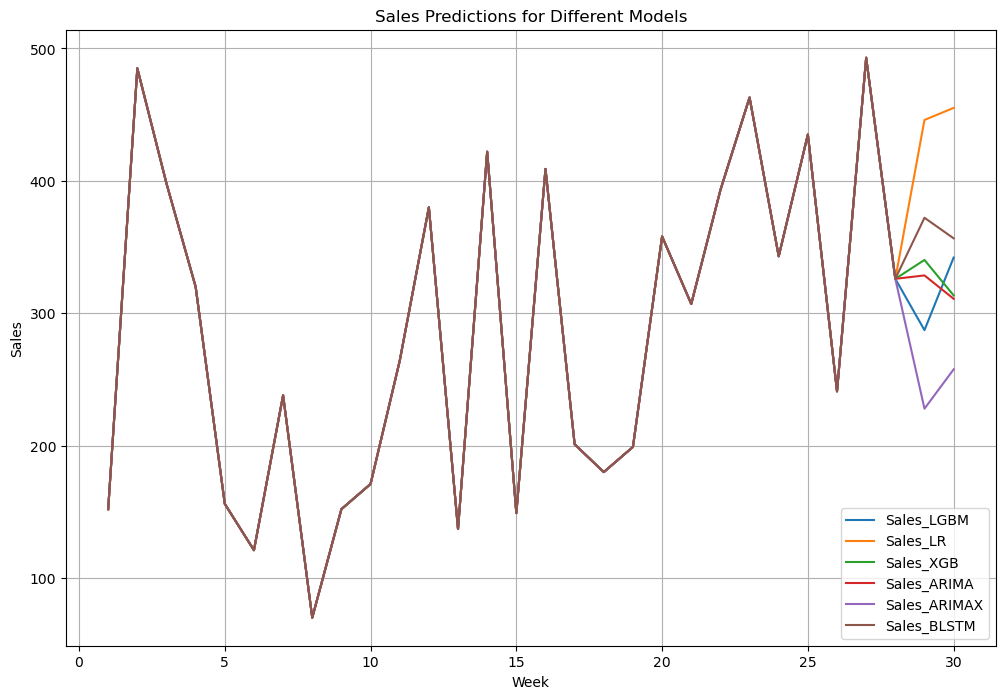

In [44]:
# Seleccionar las columnas de las ventas de los diferentes modelos
sales_columns = ['Sales_LGBM', 'Sales_LR', 'Sales_XGB', 'Sales_ARIMA', 'Sales_ARIMAX', 'Sales_BLSTM' ]

plt.figure(figsize=(12, 8))

# Graficando la predicción de ventas de cada modelo
for column in sales_columns:
    plt.plot(df_combined['Week'], df_combined[column], label=column)
    
plt.xlabel('Week')
plt.ylabel('Sales')
plt.title('Sales Predictions for Different Models')
plt.legend()
plt.grid(True)
plt.show()
